## e.g. 16: Set up a multi forecast script (based on e.g. 5).

# this will calculate z20 for CAFE + assim + SODA, modify for wwv later which is based on z20 anyway.

# might want to create output file that is written to as the system goes along so that it can be restarted, or examined part of the way through the processing?

# want to create variable which gives time after forecast, so that a plot of forecast start date V lead time can be generated. Perhaps we can look at particular ENSO events to see impact of ensemble as well as other statistics.

# want to create plots (e.g. bar diagram) summarising forecasts and their dates

# last edited 30 August 2018

In [12]:
# import os
# os.chdir('/OSM/CBR/OA_DCFP/work/col414/cafepp')

# from decadal_diag import test_reload

# import importlib

# test_reload = importlib.reload(test_reload)

# print('END')

In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
print('BEGIN')

import socket
import re
import os
import sys
import inspect
import pickle
import glob
import bz2

print('sys.version=',sys.version)

hostname=socket.gethostname()

print('hostname=',hostname)

__file__='jupyter_notebook' #this can be deleted when written to a python script and loaded as module.

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy as np
import numpy.ma as ma
from matplotlib.mlab import griddata
import itertools
from multi_forc_funcs import multi_forc_funcs

cafe_experiment_titles = {4:'v0_forecast', 1:'v1_forecast', 3:'v2_forecast', 9:'v1', \
  5:'v2', 6:'v3', 7:'aug17p', 2:'v1_assim', 10:'etkf', 11:'nov17n', 12:'jul18b', 13:'v0'}

%matplotlib inline

CRED = '\033[91m'
CEND = '\033[0m'

output_files_name='eg16_files.pkl'
input_files_name=output_files_name

print('END')

BEGIN
sys.version= 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
hostname= oa-35-cdc
END


In [33]:
print('BEGIN')

SWITCH_OFF=True #temporary for easy skipping of this section.
SWITCH_OFF=False

if(not SWITCH_OFF):
  
  import socket
  import re
  import os
  import sys

  print('sys.version=',sys.version)

  hostname=socket.gethostname()

  print('hostname=',hostname)

  if(re.match('raijin',hostname)):
    print('this is rajin')
    rundir='/short/v14/mac599/cafepp/rundir'
    topdir=''
  elif(re.match('oa-3.-cdc',hostname)):
    print('this is vm32')
    rundir='/OSM/CBR/OA_DCFP/work/col414/cafepp'
    topdir='/OSM/CBR/OA_DCFP/data/CAFEPP/CMIP6'
    topdir_soda='/OSM/CBR/OA_DCFP/data2/col414'
  else:
    raise SystemExit('host not known:'+__file__+' line number: '+str(inspect.stack()[0][2]))

  os.chdir(rundir)

  os.chdir('/OSM/CBR/OA_DCFP/work/col414/cafepp')

  print('Current Working Directory=',os.getcwd())
#===============================================================================
  
  from decadal_diag import \
    fractional_year_from_num2date, \
    generate_daily_month_indices, \
    shade_2d_latlon, \
    get_timestamp_number, \
    shade_2d_curvilinear, \
    shade_2d_simple, \
    nino_indices, \
    plot_xy, \
    restrict_input_files, \
    cmor_ripf_parts, \
    cmor_directory_parts, \
    cmor_file_parts, \
    file_spec_summary, \
    file_sort_ripf

  from n_data_funcs import n_data_funcs

#===============================================================================
  
  ivar_str_forc='t20d'
  dvar=ivar_str_forc
  grid_label='gn'
  years=range(2006,2006+1) #2002,2016+1

  forc_files_string=[]
  for icnt,year in enumerate(years):
    #to match all ensembles 1-11 use r*[0,1,2,3,4,5,6,7,8,9]i1p1f1
    forc_files_string.append(glob.glob('/OSM/CBR/OA_DCFP/data/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r*i1p1f1/Omon/'+dvar+'/'+grid_label+'/v20171025/'+dvar+ \
      '_Omon_historical_CAFE-1-0_r*[0,1,2,3,4,5,6,7,8,9]i1p1f1_'+grid_label+'_'+str(year)+'??-??????.nc'))
  merged = sorted(list(itertools.chain.from_iterable(forc_files_string)))
  forc_input_files=sorted(restrict_input_files(merged,24,60)) #72
  
  print('forc_input_files=',forc_input_files)

  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

  ivar_str_soda='t20d';ifil_prefix_soda='t20d';offset=0.0;scale=1.0;long_name='Depth of the 20C isotherm';units='m'
  idir=topdir_soda+'/SODA/dsrs.atmos.umd.edu/DATA/soda3.7.2/REGRIDED/ocean'
  soda_input_files=[[idir+'/'+ivar_str_soda+'_soda3.7.2_mn_ocean_reg_198001-201612.nc']]
  
  if(not os.path.exists(soda_input_files[0][0])):
      raise SystemExit('Input file doesnt exist,'+soda_input_files[0][0]+':'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
  print('soda_input_files=',soda_input_files)

#===============================================================================

  grid_label='gn'      
  ivar_str_assim='t20d';table='Omon'

  ensemble=1
  pval=2 #v1_assim
  assim_input_files=[]
  idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
    '/'+ivar_str_assim+'/'+grid_label+'/v20171025'
  monthly_ifils_assim=[ivar_str_assim+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
    grid_label+'_200201-201512.nc']
  for file in monthly_ifils_assim:
    if(not os.path.exists(idir+'/'+file)):
      raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
    else:
      assim_input_files.append(idir+'/'+file)
  assim_input_files=[assim_input_files]
  
  print('assim_input_files=',assim_input_files)
  
#===============================================================================

print('END')

BEGIN
sys.version= 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
hostname= oa-35-cdc
this is vm32
Current Working Directory= /OSM/CBR/OA_DCFP/work/col414/cafepp
forc_input_files= ['/OSM/CBR/OA_DCFP/data/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r10i1p1f1/Omon/t20d/gn/v20171025/t20d_Omon_historical_CAFE-1-0_r10i1p1f1_gn_200601-201012.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r10i1p1f1/Omon/t20d/gn/v20171025/t20d_Omon_historical_CAFE-1-0_r10i1p1f1_gn_200602-200801.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r10i1p1f1/Omon/t20d/gn/v20171025/t20d_Omon_historical_CAFE-1-0_r10i1p1f1_gn_200603-200802.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r10i1p1f1/Omon/t20d/gn/v20171025/t20d_Omon_historical_CAFE-1-0_r10i1p1f1_gn_200604-200803.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r10i1p1f1/Omon/t20d/gn/v20171025/t20d_Omon_historica

In [34]:
print('BEGIN')

SWITCH_OFF=True #temporary for easy skipping of this section.
SWITCH_OFF=False

if(not SWITCH_OFF):

  #Clobber=False
  Clobber=True

  if(Clobber):

    print(CRED+'overwriting output PKL file '+output_files_name+' and regenerating...'+CEND)

    pkl_objects=( \
      forc_input_files, assim_input_files, soda_input_files)

  if((os.path.exists(output_files_name) and Clobber) or (not os.path.exists(output_files_name))):
    print(CRED+'Pkl file exists and deleting...'+CEND)

    if(os.path.exists(output_files_name)): os.remove(output_files_name)

    pickling_out = open(output_files_name, "wb")
    pickle.dump( pkl_objects, pickling_out, protocol=4)
    
    #pickle.dump(d, open("file", 'w'), protocol=4)
    
    pickling_out.close()

  if(os.path.exists(output_files_name) and not Clobber):
    print(CRED+'Pkl file exists and keeping...'+CEND)
    
print('END')

BEGIN
overwriting output PKL file eg16_files.pkl and regenerating...
Pkl file exists and deleting...
END


In [35]:
print('BEGIN')

from decadal_diag import \
  file_spec_summary
  
if(os.path.exists(input_files_name)):
  pickling_in = open(input_files_name, "rb")
  forc_input_files, assim_input_files, obs_input_files \
  = pickle.load(pickling_in)
  pickling_in.close()
  
#print(forc_input_files, assim_input_files, obs_input_files)
    
#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

datetime_all,datetime_uniq,ripf_all,ripf_uniq=file_spec_summary(forc_input_files, True)

raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

test_v1=multi_forc_funcs(Diag=False, input_files=(forc_input_files, assim_input_files, obs_input_files))

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

# quantity='z20'
# quantity='wwv'

test_v1.calculate_filedatetime_info_multiforc(Diag=True, \
  quantity='z20', \
  ivars=('t20d','t20d','t20d'), \
  output_pkl='eg16_data.pkl', \
  Clobber=True, \
  ObsName='soda', \
  ObsCAYears=(1980,2016,1980,2016) )

#test_v1.calculate_filedatetime_info_multiforc(Diag=True, quantity='latlon_region', ivars=('skt','tos','tos'))

print('END')

BEGIN
len(datetime)= 132
len(datetime_uniq)= 12
len(ripf)= 132
len(ripf_uniq)= 11
# datetime count:
0 200601-201012 11
1 200602-200801 11
2 200603-200802 11
3 200604-200803 11
4 200605-200804 11
5 200606-200805 11
6 200607-201106 11
7 200608-200807 11
8 200609-200808 11
9 200610-200809 11
10 200611-200810 11
11 200612-200811 11
# ripf count:
0 r10i1p1f1 12
1 r11i1p1f1 12
2 r1i1p1f1 12
3 r2i1p1f1 12
4 r3i1p1f1 12
5 r4i1p1f1 12
6 r5i1p1f1 12
7 r6i1p1f1 12
8 r7i1p1f1 12
9 r8i1p1f1 12
10 r9i1p1f1 12


SystemExit: STOP!:jupyter_notebook line number: 16

/OSM/CBR/OA_DCFP/apps/col414/anaconda3/envs/cafepp_36_new/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


BEGIN
reading from PKL file eg16_data.pkl...
time_beg_index_keep= [265 266 267 268 269 270 271 272 273 274 275 0 264]
time_end_index_keep= [288 289 290 291 292 329 294 295 296 297 298 443 431]
quantity_monthly_ensemble.shape= (444, 11, 11, 6)
quantity_monthly_obs.shape= (444, 6)
quantity_monthly_assim.shape= (444, 6)
year_fraction_monthly_full.size= 444
datetime_uniq= ['200202-200401', '200203-200402', '200204-200403', '200205-200404', '200206-200405', '200207-200706', '200208-200407', '200209-200408', '200210-200409', '200211-200410', '200212-200411', 'Obs198001-201612', 'assim200201-201512']
len(datetime_uniq)= 13
time_units= days since 0001-01-01 00:00:00
time_calendar= julian
years_months_full= [198001, 198002, 198003, 198004, 198005, 198006, 198007, 198008, 198009, 198010, 198011, 198012, 198101, 198102, 198103, 198104, 198105, 198106, 198107, 198108, 198109, 198110, 198111, 198112, 198201, 198202, 198203, 198204, 198205, 198206, 198207, 198208, 198209, 198210, 198211, 198212, 198

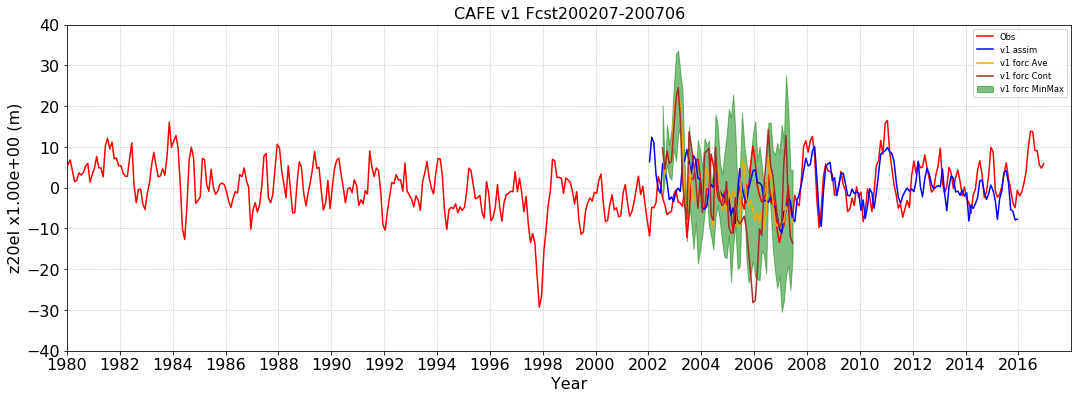

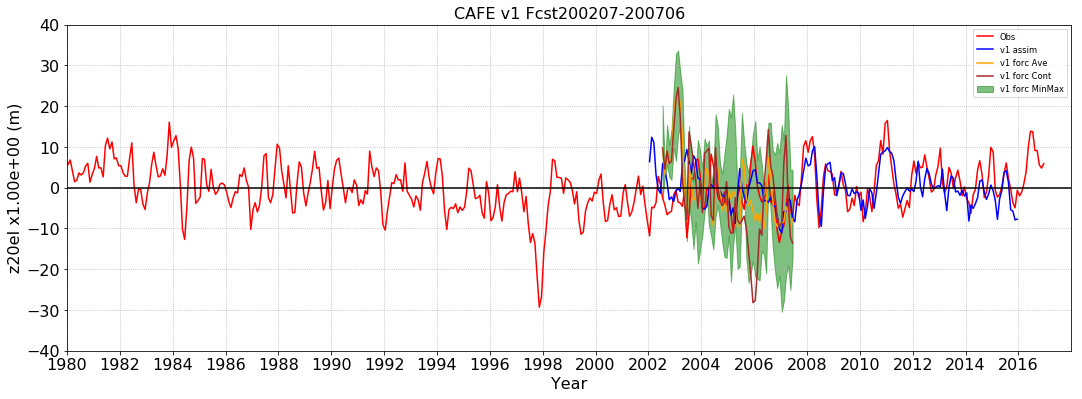

END


In [11]:
print('BEGIN')

from n_data_funcs import n_data_funcs

input_data_name='eg16_data.pkl'   

print(CRED+'reading from PKL file '+input_data_name+'...'+CEND)

from decadal_diag import check_valid_data_plot, plot_xy

if(os.path.exists(input_data_name)):
  pickling_in = bz2.BZ2File(input_data_name, "rb")
  quantity_monthly_ensemble, quantity_monthly_obs, quantity_monthly_assim, time_beg_index_keep, time_end_index_keep, \
    check_valid_data, date_full, time_full, year_fraction_monthly_full, datetime_uniq, time_units, time_calendar, \
    years_months_full, boxes, quantity \
    = pickle.load(pickling_in)
  pickling_in.close()
  
#check_valid_data_plot(Diag=False, times=date_full, forecasts=datetime_uniq, data=check_valid_data,  xysize=(15,20))

whatever_index=5

print('time_beg_index_keep=',time_beg_index_keep)
print('time_end_index_keep=',time_end_index_keep)
print('quantity_monthly_ensemble.shape=',quantity_monthly_ensemble.shape)
print('quantity_monthly_obs.shape=',quantity_monthly_obs.shape)
print('quantity_monthly_assim.shape=',quantity_monthly_assim.shape)
# print('date_full=',date_full)
# print('time_full=',time_full)
#print('year_fraction_monthly_full=',year_fraction_monthly_full)
print('year_fraction_monthly_full.size=',year_fraction_monthly_full.size)
print('datetime_uniq=',datetime_uniq)
print('len(datetime_uniq)=',len(datetime_uniq))
# print('check_valid_data=',check_valid_data)
print('time_units=',time_units)
print('time_calendar=',time_calendar)
print('years_months_full=',years_months_full)
print('len(years_months_full)=',len(years_months_full))

if(quantity=='wwv'):
  scale=1e-14
else:
  scale=1.0
  
forecast_num_to_extract=5

ZeroClim=False #default
#ZeroClim=True

zero2=True #default
#zero2=False

if(forecast_num_to_extract>len(datetime_uniq)-2-1):
  raise SystemExit('You have selected a forecast, '+str(forecast_num_to_extract)+', beyond valid range, 0:'+str(len(datetime_uniq)-2-1)+'.'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

dummy_obs = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(False, date_full, time_full, time_units, time_calendar)) #I think boolean for dummy_mode should be False but seems to work.

# cbeg_obs=2001
# cend_obs=2010
# abeg_obs=2001
# aend_obs=2010

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

quantity_monthlyclimatology_obs, quantity_monthlyanomaly_obs= \
  dummy_obs.monthly_clim_anom( \
  Diag=False, input=quantity_monthly_obs, AnnOut=False, ZeroClim=ZeroClim) #, \
#   cbeg=cbeg_obs, cend=cend_obs, abeg=abeg_obs, aend=aend_obs)

print('quantity_monthlyclimatology_obs.shape=',quantity_monthlyclimatology_obs.shape)
print('quantity_monthlyanomaly_obs.shape=',quantity_monthlyanomaly_obs.shape)

#===============================================================================

dummy_assim = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(False, date_full, time_full, time_units, time_calendar)) #I think boolean for dummy_mode should be False but seems to work.

# cbeg_assim=2002
# cend_assim=2015
# abeg_assim=2002
# aend_assim=2015

cafe_quantity_monthlyclimatology_assim, cafe_quantity_monthlyanomaly_assim= \
  dummy_assim.monthly_clim_anom( \
  Diag=False, input=quantity_monthly_assim, AnnOut=False, ZeroClim=ZeroClim) #, \
#   cbeg=cbeg_assim, cend=cend_assim, abeg=abeg_assim, aend=aend_assim)

print('cafe_quantity_monthlyclimatology_assim.shape=',cafe_quantity_monthlyclimatology_assim.shape)
print('cafe_quantity_monthlyanomaly_assim.shape=',cafe_quantity_monthlyanomaly_assim.shape)

#===============================================================================

dummy_v1forc = n_data_funcs(Diag=True, input_files=None, input_var_name=None, \
  dummy_mode=(False, date_full, time_full, time_units, time_calendar)) #I think boolean for dummy_mode should be False but seems to work.

# cbeg_v1forc=2001
# cend_v1forc=2015
# abeg_v1forc=2001
# aend_v1forc=2015

#print(quantity_monthly_ensemble.shape)

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

clim_shape_v1=[dummy_assim.nmy, *quantity_monthly_ensemble.shape[1::]]

print('clim_shape_v1=',clim_shape_v1)

#need to build up clim
clim_for_v1=ma.zeros(clim_shape_v1,dtype='f') #nmy, ensembles, forecasts, nino
for enow in range(clim_shape_v1[1]):
  for fnow in range(clim_shape_v1[2]):
    clim_for_v1[:,enow,fnow,:]=cafe_quantity_monthlyclimatology_assim #12, 4
    
print('clim_for_v1.shape=',clim_for_v1.shape)

cafe_quantity_monthlyanomaly_v1forc= \
  dummy_v1forc.monthly_clim_anom( \
  Diag=True, input=quantity_monthly_ensemble, AnnOut=False, ZeroClim=ZeroClim, \
  clim=clim_for_v1) #cbeg=cbeg_v1forc, cend=cend_v1forc, abeg=abeg_v1forc, aend=aend_v1forc)
  
print('cafe_quantity_monthlyanomaly_v1forc.shape=',cafe_quantity_monthlyanomaly_v1forc.shape)
  
#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

input_xvals = (dummy_obs.year_fraction_anomaly,)
input_datas = (quantity_monthlyanomaly_obs[:,whatever_index]*scale,) #obs

input_xvals = input_xvals + (dummy_assim.year_fraction_anomaly,)
input_datas = input_datas + (cafe_quantity_monthlyanomaly_assim[:,whatever_index]*scale,) #assim

input_xvals = input_xvals + (dummy_v1forc.year_fraction_anomaly,)
input_xvals = input_xvals + (dummy_v1forc.year_fraction_anomaly,)
input_xvals = input_xvals + (dummy_v1forc.year_fraction_anomaly,)
input_xvals = input_xvals + (dummy_v1forc.year_fraction_anomaly,)

#ensemble at 0 is control run, so ignore it in ensemble stats.
input_datas = input_datas + (np.min(cafe_quantity_monthlyanomaly_v1forc[:,1::,forecast_num_to_extract,whatever_index],axis=1)*scale,)
input_datas = input_datas + (np.max(cafe_quantity_monthlyanomaly_v1forc[:,1::,forecast_num_to_extract,whatever_index],axis=1)*scale,)
input_datas = input_datas + (np.average(cafe_quantity_monthlyanomaly_v1forc[:,1::,forecast_num_to_extract,whatever_index],axis=1)*scale,)
input_datas = input_datas + (cafe_quantity_monthlyanomaly_v1forc[:,0,forecast_num_to_extract,whatever_index]*scale,) #control ensemble

plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
  title='CAFE v1 Fcst'+datetime_uniq[forecast_num_to_extract], \
  units=boxes[whatever_index].split(',')[1], \
  xlab='Year', \
  ylab=boxes[whatever_index].split(',')[0]+' x'+str('{:.2e}'.format(1.0/scale)) + ' ('+boxes[whatever_index].split(',')[1]+')', \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  line_colors=['red','blue','green','orange','brown'], \
  line_labels=['Obs','v1 assim','v1 forc MinMax','v1 forc Ave','v1 forc Cont'], \
  legend_position='best', \
  fill_between=[0,1,2,2,3,4], \
  line_alphas=[1.,1.,.5,1.,1.], \
  xlim=[1980,2018], \
  xticks=np.arange(1980,2018,2), \
  grid=True, \
  grid_linestyle='dotted', \
  legend_fontsize='small', \
  xysize=(18,6))
  
#===============================================================================

#plot first diagram, but specify exact beg/end time points of each data set.

input_xvals = (dummy_obs.year_fraction_anomaly[time_beg_index_keep[-2]:time_end_index_keep[-2]+1],)
input_datas = (quantity_monthlyanomaly_obs[time_beg_index_keep[-2]:time_end_index_keep[-2]+1,whatever_index]*scale,) #obs

input_xvals = input_xvals + (dummy_assim.year_fraction_anomaly[time_beg_index_keep[-1]:time_end_index_keep[-1]+1],)
input_datas = input_datas + (cafe_quantity_monthlyanomaly_assim[time_beg_index_keep[-1]:time_end_index_keep[-1]+1,whatever_index]*scale,) #assim

input_xvals = input_xvals + (dummy_v1forc.year_fraction_anomaly[time_beg_index_keep[forecast_num_to_extract]:time_end_index_keep[forecast_num_to_extract]+1],)
input_xvals = input_xvals + (dummy_v1forc.year_fraction_anomaly[time_beg_index_keep[forecast_num_to_extract]:time_end_index_keep[forecast_num_to_extract]+1],)
input_xvals = input_xvals + (dummy_v1forc.year_fraction_anomaly[time_beg_index_keep[forecast_num_to_extract]:time_end_index_keep[forecast_num_to_extract]+1],)
input_xvals = input_xvals + (dummy_v1forc.year_fraction_anomaly[time_beg_index_keep[forecast_num_to_extract]:time_end_index_keep[forecast_num_to_extract]+1],)

#ensemble at 0 is control run, so ignore it in ensemble stats.
input_datas = input_datas + (np.min(cafe_quantity_monthlyanomaly_v1forc[time_beg_index_keep[forecast_num_to_extract]:time_end_index_keep[forecast_num_to_extract]+1,1::,forecast_num_to_extract,whatever_index],axis=1)*scale,)
input_datas = input_datas + (np.max(cafe_quantity_monthlyanomaly_v1forc[time_beg_index_keep[forecast_num_to_extract]:time_end_index_keep[forecast_num_to_extract]+1,1::,forecast_num_to_extract,whatever_index],axis=1)*scale,)
input_datas = input_datas + (np.average(cafe_quantity_monthlyanomaly_v1forc[time_beg_index_keep[forecast_num_to_extract]:time_end_index_keep[forecast_num_to_extract]+1,1::,forecast_num_to_extract,whatever_index],axis=1)*scale,)
input_datas = input_datas + (cafe_quantity_monthlyanomaly_v1forc[time_beg_index_keep[forecast_num_to_extract]:time_end_index_keep[forecast_num_to_extract]+1,0,forecast_num_to_extract,whatever_index]*scale,) #control ensemble

#print(dummy_v1forc.year_fraction_anomaly)
#print(time_beg_index_keep[forecast_num_to_extract],time_end_index_keep[forecast_num_to_extract])
#print(year_fraction_monthly_full[time_beg_index_keep[forecast_num_to_extract]:time_end_index_keep[forecast_num_to_extract]+1])
#print(dummy_v1forc.year_fraction_anomaly[time_beg_index_keep[forecast_num_to_extract]:time_end_index_keep[forecast_num_to_extract]+1])
#print(cafe_quantity_monthlyanomaly_v1forc[time_beg_index_keep[forecast_num_to_extract]:time_end_index_keep[forecast_num_to_extract]+1,0,forecast_num_to_extract,whatever_index])
       
#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))


plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
  title='CAFE v1 Fcst'+datetime_uniq[forecast_num_to_extract], \
  units=boxes[whatever_index].split(',')[1], \
  xlab='Year', \
  ylab=boxes[whatever_index].split(',')[0]+' x'+str('{:.2e}'.format(1.0/scale)) + ' ('+boxes[whatever_index].split(',')[1]+')', \
  zero2=zero2, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  line_colors=['red','blue','green','orange','brown'], \
  line_labels=['Obs','v1 assim','v1 forc MinMax','v1 forc Ave','v1 forc Cont'], \
  legend_position='best', \
  fill_between=[0,1,2,2,3,4], \
  line_alphas=[1.,1.,.5,1.,1.], \
  xlim=[1980,2018], \
  xticks=np.arange(1980,2018,2), \
  grid=True, \
  grid_linestyle='dotted', \
  legend_fontsize='small', \
  xysize=(18,6))

print('END')

In [ ]:
quantity

boxes